<img style="float: left;" src="./images/PalleAI-Banner1.png" width="800">

# Build a Segmentation Model with CNN's on Oxford Pets-III dataset

<img style="float: left;" src="./images/pet_annotations2.jpg" width="400">

### Import needed libraries 

In [1]:
#Basic Python packages for data wrangling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random

#Tensorflow & Keras related packages
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.utils import load_img, img_to_array

from utils import plot_history

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### Download Oxford Pets III Dataset Preloaded in Keras

https://www.robots.ox.ac.uk/~vgg/data/pets/

**images:** http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

**segmentation masks:** http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

### Load & Understand the Data

In [3]:
# Once you have downloaded the data
# Create paths to where images and the corresponding annotations are located
base_dir = Path("oxford-pets_data")

# Directory where images are stored
images_dir = base_dir / "images"

# Directory where segmentation masks or labels are stored
masks_dir = base_dir / "annotations" / "trimaps"

In [4]:
print (images_dir)

oxford-pets_data\images


In [5]:
print (masks_dir)

oxford-pets_data\annotations\trimaps


**First, load the paths of each file**

In [6]:
images_paths = sorted([img_path for img_path in images_dir.iterdir() if img_path.suffix == ".jpg"])
masks_paths = sorted([mask_path for mask_path in masks_dir.iterdir() if not mask_path.name.startswith(".")])

In [7]:
# # First, load the paths of each file
# images_paths = [img_path for img_path in images_dir.iterdir() if img_path.suffix == ".jpg"]
# masks_paths = [mask_path for mask_path in masks_dir.iterdir() if not mask_path.name.startswith(".")]

In [8]:
images_paths[0]

WindowsPath('oxford-pets_data/images/Abyssinian_1.jpg')

In [9]:
masks_paths[0]

WindowsPath('oxford-pets_data/annotations/trimaps/Abyssinian_1.png')

In [10]:
random.Random(42).shuffle(images_paths)
random.Random(42).shuffle(masks_paths)

In [11]:
images_paths[0]

WindowsPath('oxford-pets_data/images/shiba_inu_65.jpg')

In [12]:
masks_paths[0]

WindowsPath('oxford-pets_data/annotations/trimaps/shiba_inu_65.png')

**Load the images & corresponding mask labels and preproces them**

In [13]:
images = [img_to_array(load_img(path)) for path in images_paths[0:2]]

In [14]:
images[0].shape

(500, 375, 3)

In [15]:
len(images_paths)

7390

In [16]:
# Lets resize images and store them 
images = [img_to_array(load_img(path, target_size = (200,200))) for path in images_paths]

In [17]:
images[0].shape

(200, 200, 3)

In [18]:
# For mask labels, these are also of 2D image shape, but the pixel values for these images are labels

# 1 (foreground)
# 2 (background)
# 3 (contour)

# So we convert these mask labels into integers and substract by 1, to get values of 0, 1, 2
# also we choose grayscale when we load the mask image to represent a single color channel


mask_labels = [img_to_array(load_img(path, target_size = (200,200),color_mode="grayscale"))
               .astype('uint8')-1
                for path in masks_paths]

In [19]:
mask_labels[0].shape

(200, 200, 1)

In [20]:
# Now lets convert the list of images & labels into numpy arrays

images = np.stack(images)
mask_labels = np.stack(mask_labels)

print (images.shape)
print (mask_labels.shape)

(7390, 200, 200, 3)
(7390, 200, 200, 1)


In [21]:
# so we have around 7390 images & corresponding masks which are greyscale images

**Lets look at a single image**

In [22]:
# data type of the values inside the images array
images.dtype

dtype('float32')

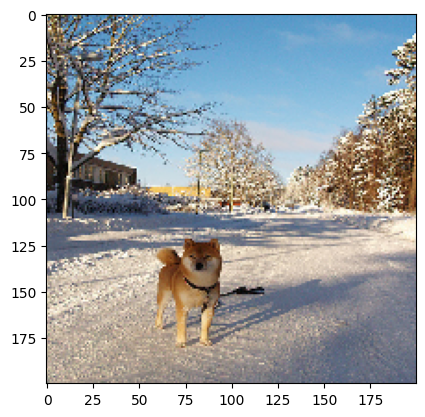

In [23]:
# Lets visualize a sample image

# matplotlib expects image data to be in the range [0, 1] for floating-point arrays 
#...and [0, 255] for integer arrays. 

plt.imshow(images[0]/255.0)
plt.show()

**Now lets look at the corresponding mask labels**

In [24]:
# mask_labels are also images corresponding to acutal pets images 
#...but with values representing the mask labels

mask_labels.shape 

(7390, 200, 200, 1)

In [25]:
mask_labels.dtype

dtype('uint8')

In [26]:
np.unique(mask_labels[0]) # These are the unique values in the mask_labels images. 0, 1, 2

array([0, 1, 2], dtype=uint8)

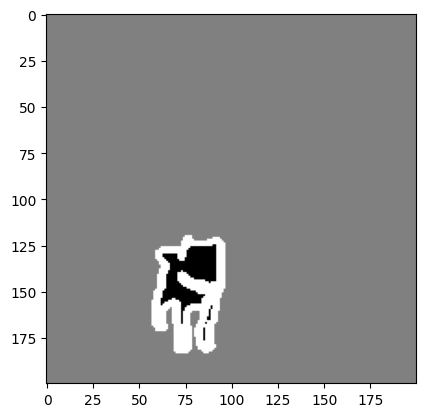

In [27]:
# Lets visualize the mask label image
plt.imshow(mask_labels[0], cmap = "gray")

# cmap='gray': This sets the colormap to grayscale, 
# ensuring that the image is displayed using shades of gray rather than the default colormap.

plt.show()

### Split data into Train, Valid

In [28]:
len(images)

7390

In [29]:
# We will use around 1000 samples for validation data

train_images = images[:6390]
train_masks = mask_labels[:6390]

val_images = images[6390:]
val_masks = mask_labels[6390:]

In [30]:
train_images.shape

(6390, 200, 200, 3)

In [31]:
val_images.shape

(1000, 200, 200, 3)

### Build the model architecture

In [32]:
# Unlike classification tasks, for segmentation as u see below we will use strided convolutions
# Strided convolutions are better at retaining local spatial information compared to maxpooling layers.

def segmentation_model():
    
    # Define input
    inputs = keras.Input(shape=(200,200,3))
    
    # Rescaling layer
    x = layers.Rescaling(1.0/255)(inputs)
    
    # First half of the architecture focuses on encoding images into smaller feature maps
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # 2nd half of the architecture focuses on upsampling the image back to be of same shape as our mask _label images
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(3, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

In [33]:
model = segmentation_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [37]:
mask_labels.shape #actual Y mask labels.

(7390, 200, 200, 1)

## Compile the Model

In [36]:
# Compile the model
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Callbacks

# model_checkpoint = keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", 
#                                     monitor="val_loss",
#                                     save_best_only=True)

# early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", 
#                                            patience=3, 
#                                            restore_best_weights=True)

# callbacks = [early_stop] 

In [38]:
history = model.fit(train_images, train_masks,
                    epochs=50,
                    batch_size=16,
                    validation_data=(val_images, val_masks))

Epoch 1/50
400/400 [==============================] - 54s 105ms/step - loss: 1.5339 - accuracy: 0.6272 - val_loss: 0.7998 - val_accuracy: 0.6816
Epoch 2/50
400/400 [==============================] - 39s 98ms/step - loss: 0.7370 - accuracy: 0.7002 - val_loss: 0.6448 - val_accuracy: 0.7352
Epoch 3/50
400/400 [==============================] - 39s 98ms/step - loss: 0.6364 - accuracy: 0.7414 - val_loss: 0.6106 - val_accuracy: 0.7529
Epoch 4/50
400/400 [==============================] - 40s 99ms/step - loss: 0.5716 - accuracy: 0.7715 - val_loss: 0.7279 - val_accuracy: 0.6984
Epoch 5/50
400/400 [==============================] - 39s 98ms/step - loss: 0.5283 - accuracy: 0.7918 - val_loss: 0.5161 - val_accuracy: 0.8007
Epoch 6/50
400/400 [==============================] - 39s 98ms/step - loss: 0.4964 - accuracy: 0.8057 - val_loss: 0.6835 - val_accuracy: 0.7456
Epoch 7/50
400/400 [==============================] - 39s 98ms/step - loss: 0.4666 - accuracy: 0.8181 - val_loss: 0.4729 - val_accuracy

### Plotting the loss & Accuracy curves

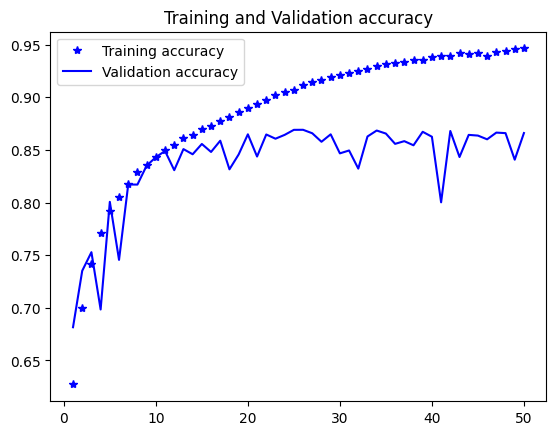

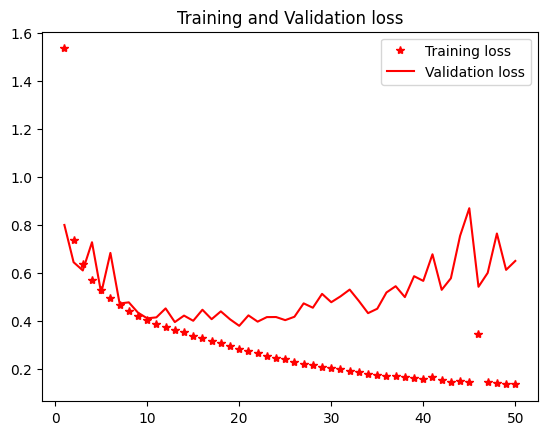

In [39]:
plot_history(history)